In [1]:
import sys
import os
import pandas as pd
import seaborn as sns


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/step0045_params.pickle'
icenode_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/config.json'

# RETAIN trained on MIMIC-III training partition (70%)
retain_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/step0099_params.pickle'
retain_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/config.json'

# GRU=GRAM/M trained on MIMIC-III training partition (70%)
gru_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/step0096_params.pickle'
gru_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/config.json'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

2022-02-22 19:56:54.441642: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [6]:
retain_patient_interface = RETAIN.create_patient_interface(mimic3_dir, 'M3')
gram_patient_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [7]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Config/Params

In [8]:
from icenode.utils import load_config, load_params

icenode_config = load_config(icenode_m3_config)
icenode_params = load_params(icenode_m3_params)

retain_config = load_config(retain_m3_config)
retain_params = load_params(retain_m3_params)

gru_config = load_config(gru_m3_config)
gru_params = load_params(gru_m3_params)

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Load Models

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
icenode_state = icenode.init_with_params(icenode_config, icenode_params)

retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
retain_state = retain.init_with_params(retain_config, retain_params)


gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
gru_state = gru.init_with_params(gru_config, gru_params)


## Per-code performance

In [10]:
from icenode.metrics import codes_auc_pairwise_tests

In [11]:
test_res = {
    'ICENODE': icenode.eval(icenode_state, test_ids)['diag_detectability'],
    'RETAIN': retain.eval(retain_state, test_ids)['diag_detectability'],
    'GRU': gru.eval(gru_state, test_ids)['diag_detectability']
}

In [12]:
tests_raw = codes_auc_pairwise_tests(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:03<00:00,  3.81it/s]


## Correlation between AUC and N_POS_CODES

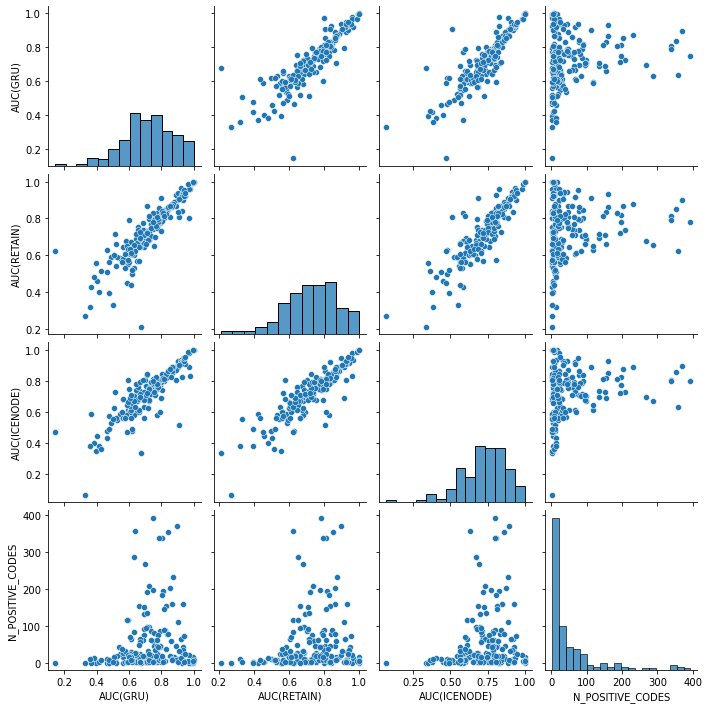

In [13]:
tests_raw_auc_corr = tests_raw[[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')] + ['N_POSITIVE_CODES']]
sns.pairplot(tests_raw_auc_corr)

In [15]:
flatccs_idx2code = {idx: code for code, idx in icnode_patient_interface.diag_flatccs_idx.items()}
idx2desc = lambda i: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
tests_raw['DESC'] = tests_raw['CODE_INDEX'].apply(idx2desc)
tests_raw

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.489303,0.525622,0.590547,0.869250,0.586623,0.597493,No DX
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810838,0.811493,0.663989,0.670746,0.953879,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797534,0.781738,0.000016,0.000026,0.061384,Maint chem/r


In [16]:
# remove codes that no classifier has scored above 0.6
at_least_AUC_06 = tests_raw.loc[:,[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')]].max(axis=1) > 0.6
tests = tests_raw[at_least_AUC_06]
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810838,0.811493,0.663989,0.670746,0.953879,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797534,0.781738,0.000016,0.000026,0.061384,Maint chem/r


In [17]:
tests.isnull().sum()

CODE_INDEX                     0
N_POSITIVE_CODES               0
AUC(GRU)                       0
AUC(ICENODE)                   0
AUC(RETAIN)                    0
P0(AUC_GRU==AUC_ICENODE)       0
P0(AUC_GRU==AUC_RETAIN)        1
P0(AUC_ICENODE==AUC_RETAIN)    0
DESC                           0
dtype: int64

In [18]:
# remove the code with null p-value
tests = tests[tests['P0(AUC_GRU==AUC_RETAIN)'].notnull()]

In [19]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = ('GRU', 'ICENODE', 'RETAIN')
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(clfs_pairs)

In [20]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [21]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [22]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
...,...,...,...,...,...,...,...,...,...
168,168,78.0,0.841169,0.861646,0.860062,0.133344,0.110693,0.910440,Kidny/rnl ca
172,172,33.0,0.906483,0.901422,0.902105,0.536586,0.572521,0.927216,Hodgkin-s ds
177,177,8.0,0.611763,0.562313,0.435814,0.543028,0.064814,0.248530,Ot primry ca
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig


In [23]:
competing_tests = tests.drop(index=common_perf.index)

In [24]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [25]:
# Prepare for using Upset plot

upset_contents = {}
for clf in clfs:
    upset_contents[clf] = auc_sets[clf] | auc_sets[clfs]
    
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            upset_contents[clf].update(auc_sets[(clf1, clf2)])
    

In [26]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [27]:
upset_contents = from_contents(upset_contents)

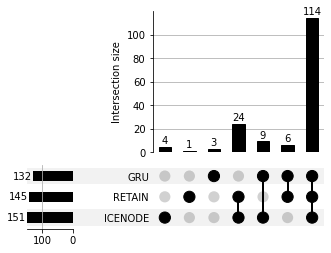

In [28]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()

In [29]:
icenode_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['ICENODE'])]
retain_best_tests =  competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['RETAIN'])]
gru_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['GRU'])]

In [30]:
icenode_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
47,47,20.0,0.655662,0.759808,0.645096,0.034159,0.821472,0.029197,Gastritis
112,112,85.0,0.632353,0.704966,0.622880,0.007767,0.679989,0.000373,Ot respir ca
126,126,29.0,0.564532,0.680225,0.578501,0.015012,0.719884,0.040162,Ot bone dx
169,169,17.0,0.614148,0.707424,0.611065,0.001978,0.915220,0.000749,Uriny org ca


In [31]:
retain_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
156,156,75.0,0.938601,0.942655,0.955774,0.463446,0.015558,0.040518,Uterus cancr


In [32]:
gru_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
21,21,98.0,0.725419,0.671509,0.681769,2.462299e-02,0.019013,0.612399,Ot circul dx
27,27,2.0,0.977656,0.828699,0.957299,1.199828e-03,0.000406,0.002475,Pneumonia
52,52,10.0,0.909910,0.513013,0.806907,2.910674e-09,0.000022,0.000009,Int obstruct


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [35]:
icenode_visit_auc_df = icenode.admissions_auc_scores(icenode_state, test_ids)

In [37]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean'], 'R/T': ['min', 'max', 'mean'] })


In [38]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.95)]

In [43]:
ccs_history = {i: icnode_patient_interface.diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [44]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_tests['CODE_INDEX']))> 0}

In [45]:
ccs_history_icenode_best

{6828: [64, 27, 209, 213, 39, 192, 196, 37, 44, 118, 126],
 7118: [111,
  60,
  37,
  185,
  47,
  238,
  125,
  9,
  65,
  155,
  64,
  66,
  27,
  21,
  164,
  192,
  241,
  196,
  44,
  11,
  200,
  198,
  4,
  3,
  18],
 11861: [71,
  68,
  215,
  60,
  158,
  63,
  61,
  190,
  240,
  64,
  157,
  76,
  209,
  184,
  164,
  192,
  203,
  200,
  44,
  118,
  195,
  198,
  201,
  187,
  111,
  22,
  41,
  37,
  47,
  125,
  146,
  9,
  189,
  62,
  65,
  5,
  155,
  66,
  58,
  27,
  48,
  241,
  237,
  196,
  113,
  121,
  108,
  175],
 18430: [64, 197, 212, 187, 58, 192, 196, 37, 47, 190, 224, 240],
 20217: [53, 60, 47, 196, 205, 200, 238, 198, 4, 190, 3, 240],
 25510: [22, 60, 47, 185, 240, 67, 64, 66, 58, 164, 50, 192, 196, 44, 21],
 30820: [212,
  53,
  60,
  47,
  185,
  189,
  240,
  190,
  64,
  58,
  27,
  209,
  48,
  192,
  196,
  195,
  44,
  25,
  200,
  198],
 31170: [212, 209, 184, 22, 48, 60, 195, 200, 44, 47, 198, 155],
 51178: [212, 47, 147, 190, 240, 64, 58, 184, 

In [46]:
len(ccs_history_icenode_best)

15

In [47]:
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 2)

  0%|                                                                                                                                                                               | 0/41 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 33/41 [1:04:36<15:39, 117.47s/it]


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
data = {}
for i, traj in trajectory.items():
    ccs_idx = list(icenode_best_tests['CODE_INDEX'])
    idx2desc = lambda i: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
    ccs_desc = map(idx2desc, ccs_idx)
    
    t = traj['t']
    d = traj['d']

    prob = []
    time = []
    code = []
    tp = []
    for ccs_desc, ccs_i in zip(ccs_desc, ccs_idx):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_i])
    
    prob = np.hstack(prob)
    time = np.hstack(time)
    data[i] = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    

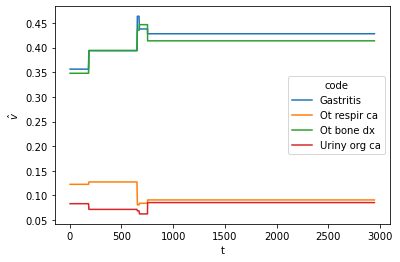

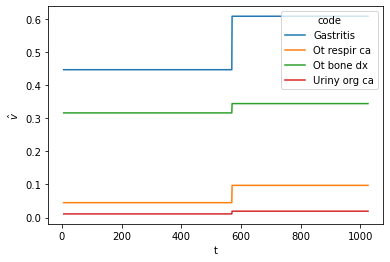

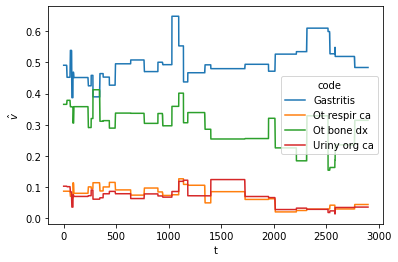

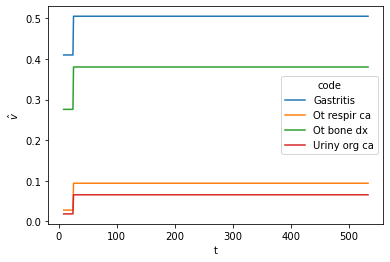

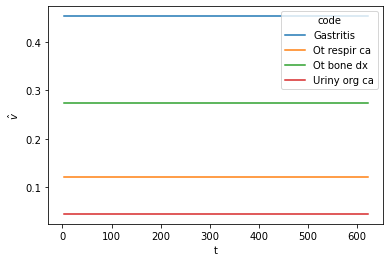

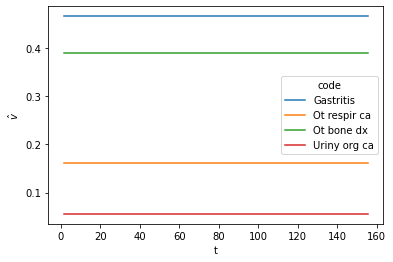

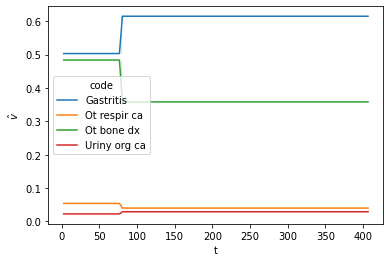

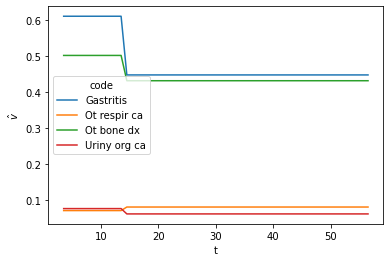

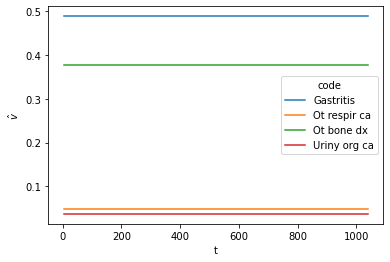

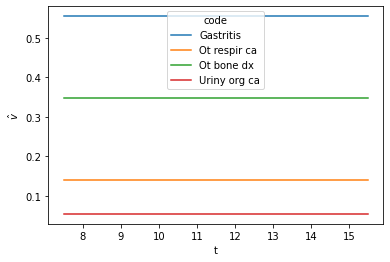

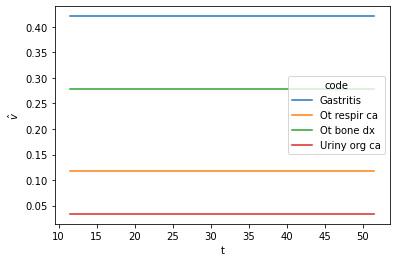

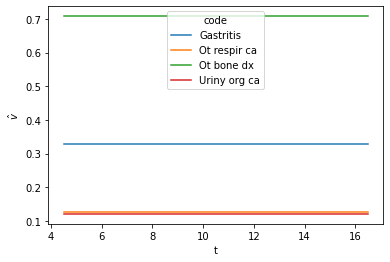

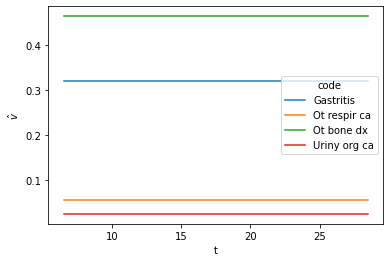

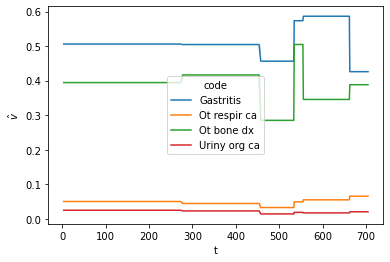

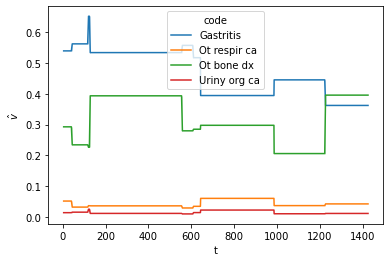

In [64]:
for i in data:
    plt.figure(i)
    sns.lineplot(data=data[i], x="t", y=r'$\hat{v}$', hue='code')

In [62]:
icenode_params

{'f_n_ode': FlatMap({
   'f_n_ode/~/ode_dyn_augment/~/ode_dyn/~/lin_0': FlatMap({
                                                    'w': array([[ 5.00074066e-06,  1.32731593e-05, -3.70061434e-06, ...,
                                                                  1.51996628e-05, -1.67694725e-05,  2.11003854e-08],
                                                                [ 9.04515764e-06, -6.77547476e-08, -5.17632270e-06, ...,
                                                                  2.67995038e-05, -1.10279495e-06,  2.95951359e-05],
                                                                [ 2.73082496e-05, -4.16996591e-06, -1.06071343e-06, ...,
                                                                  3.98258562e-05,  1.79413964e-05, -6.63200581e-06],
                                                                ...,
                                                                [-1.90205683e-05,  5.24731558e-06, -2.28550343e-05, ...,
              